# Traditional machine learning models for age prediction on EEG data

This notebook uses traditional ML methods to predict the age of infants using EEG data. The EEG data is preprocessed and features are extracted as shown in the notebook 'Deep learning EEG_dataset preprocessing'. 

In [1]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_MODELS, PATH_DATA_PROCESSED_ML

## Load preprocessed data

Steps:

1. Get all the files in the output folder
2. Get the full paths of the files without the .h5 or .csv extensions
3. Load the features from the .h5 files
4. Assign the proper labels to the files based on the metadata
5. Assign the subject's code to the files based on the metadata
6. Split the data into a training, validation and test set (NOTE: make sure data points from same subjects don't end up in same set

In [2]:
%%time

from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_ML)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_ML, file_name))[0] for file_name in fnmatch.filter(file_names, "*.h5")]

# Step 3: Load the features
frames = []

for idx, feature_file in enumerate(files):
    df_features = pd.read_hdf(feature_file + ".h5")
    df_metadata = pd.read_csv(feature_file.replace("extracted_features_", "processed_data_") + ".csv")
    
    # Step 4: Assign labels
    df_features['label'] = df_metadata['age_months'][0]
    
    # Step 5: Assign subject code
    df_features['code'] = df_metadata['code'][0]
    frames.append(df_features)

df = pd.concat(frames) 

# Step 6: List all the unique subject IDs
subject_ids = list(set(df["code"].tolist()))

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

# Step 7: Split the DataFrames into train, validation and test
df_train = df[df['code'].isin(IDs_train)]
df_val = df[df['code'].isin(IDs_val)]
df_test = df[df['code'].isin(IDs_test)]

feature_names = df.columns.values

CPU times: user 39.2 s, sys: 17.8 s, total: 57 s
Wall time: 2min 10s


In [3]:
print(f"Train/val/test proportions: {len(df_train)/len(df)}/{len(df_val)/len(df)}/{len(df_test)/len(df)}")

Train/val/test proportions: 0.6921369209525432/0.15336392297958845/0.15449915606786838


In [4]:
%%time

X_train = df_train.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_train = df_train['label'].reset_index(drop=True)
codes_train = df_train['code'].reset_index(drop=True)

X_val = df_val.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_val = df_val['label'].reset_index(drop=True)
codes_val = df_val['code'].reset_index(drop=True)

X_test = df_test.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_test = df_test['label'].reset_index(drop=True)
codes_test = df_test['code'].reset_index(drop=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

# MARK: reducing from 64 bit float to 32 bit float, to reduce memory usage
X_train = pd.DataFrame(scaler.fit_transform(X_train)).astype('float32')
X_val = pd.DataFrame(scaler.fit_transform(X_val)).astype('float32')
X_test = pd.DataFrame(scaler.fit_transform(X_test)).astype('float32')

CPU times: user 19.9 s, sys: 28.7 s, total: 48.6 s
Wall time: 1min 4s


For the ML models, the data set has been split into train and test. Only for the simple feedforward neural network, we've also used a validation set (taken from the train set). The test set remains the same.

In [5]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
codes_train_val = pd.concat([codes_train, codes_val])

In [6]:
del(file_names, files, df, frames, df_features, df_metadata, df_train, df_test, df_val, IDs_train, IDs_val, IDs_test, IDs_temp)

In [7]:
print(f"{X_train.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_train.memory_usage(deep=True)/1000000000}")
print(f"{codes_train.memory_usage(deep=True)/1000000000}")
print(f"{X_val.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_val.memory_usage(deep=True)/1000000000}")
print(f"{codes_val.memory_usage(deep=True)/1000000000}")
print(f"{X_train_val.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_train_val.memory_usage(deep=True)/1000000000}")
print(f"{codes_train_val.memory_usage(deep=True)/1000000000}")
print(f"{X_test.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_test.memory_usage(deep=True)/1000000000}")
print(f"{codes_test.memory_usage(deep=True)/1000000000}")

1.704319328
0.00757488
0.00757488
0.377643728
0.001678544
0.001678544
2.091215968
0.018506336
0.018506336
0.380439128
0.001690968
0.001690968


In [8]:
# del(X_train, y_train, codes_train, X_val, y_val, codes_val)

In [9]:
from sklearn.utils import shuffle

# Shuffle data before using
X_train_val, y_train_val, codes_train_val = shuffle(X_train_val, y_train_val, codes_train_val, random_state=42)

chunked_X_train = np.array_split(X_train_val, 100)    
chunked_y_train = np.array_split(y_train_val, 100)

## Dummy regressor

Firstly, we make predictions with dummy regressors as a simple baseline to see whether other models learn "something". From the sklearn docs: "DummyRegressor is a regressor that makes predictions using simple rules. This regressor is useful as a simple baseline to compare with other (real) regressors."

In [8]:
%%time

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_val, y_train_val)

# R2
score = dummy_regr.score(X_test, y_test)

# MSE
predictions = dummy_regr.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Dummy regressor (mean): R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Dummy regressor (mean): R-squared = -0.0005050753496549376, RMSE = 10.568698225930978 and MAE = 8.994647324440326.


In [9]:
%%time

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_val, y_train_val)

# R2
score = dummy_regr.score(X_test, y_test)

# MSE
predictions = dummy_regr.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Dummy regressor (median): R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Dummy regressor (median): R-squared = -0.037710051301526715, RMSE = 10.763409437898787 and MAE = 8.977434647867335.


## Model 1: Random Forest regressor

In [8]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# NOTE: Gridsearch was extended after initial search, therefore the results 
# for max_features = 40, 60, 70, 80, 90, 100, 150, 250, None can be found in 
# "RF_gridsearchX.joblib" files (X = 2, 3, 4)

parameters = { 
              'max_features': ['sqrt', 'log2', 15, 30, 40, 50, 60, 70, 80, 90, 100, 150, 250, None],
              'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
             }

RF_gridsearch = GridSearchCV(RandomForestRegressor(n_estimators=100, verbose=10, n_jobs=-1), 
                             parameters, verbose=10, n_jobs=1)

RF_gridsearch.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'RF_gridsearch.joblib')
dump(RF_gridsearch, output_file)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] max_features=sqrt, min_samples_leaf=1 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.5min remaining:   38.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.4min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, score=0.439, total=16.4min
[CV] max_features=sqrt, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.2min remaining:   38.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 32.6min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, score=0.365, total=16.2min
[CV] max_features=sqrt, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.9min remaining:   39.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.7s finished


[CV]  max_features=sqrt, min_samples_leaf=1, score=0.284, total=16.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 49.5min remaining:    0.0s


[CV] max_features=sqrt, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.1min remaining:   32.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:   10.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 63.7min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, score=0.332, total=14.2min
[CV] max_features=sqrt, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.5min remaining:   38.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:   12.8s remaining:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 80.5min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, score=0.344, total=16.7min
[CV] max_features=sqrt, min_samples_leaf=2 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 14.1min remaining:   35.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished


[CV]  max_features=sqrt, min_samples_leaf=2, score=0.442, total=15.0min
[CV] max_features=sqrt, min_samples_leaf=2 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 95.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.7min remaining:   34.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.9s finished


[CV]  max_features=sqrt, min_samples_leaf=2, score=0.367, total=14.7min
[CV] max_features=sqrt, min_samples_leaf=2 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 110.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.0min remaining:   40.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.7s finished


[CV]  max_features=sqrt, min_samples_leaf=2, score=0.284, total=17.0min
[CV] max_features=sqrt, min_samples_leaf=2 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 127.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 17.4min remaining:   43.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.1s finished


[CV]  max_features=sqrt, min_samples_leaf=2, score=0.334, total=18.6min
[CV] max_features=sqrt, min_samples_leaf=2 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 145.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 115.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 116.8min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 117.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV]  max_features=sqrt, min_samples_leaf=2, score=0.344, total=117.5min
[CV] max_features=sqrt, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.8min remaining:   24.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.2s finished


[CV]  max_features=sqrt, min_samples_leaf=3, score=0.442, total=10.5min
[CV] max_features=sqrt, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 10.0min remaining:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.2s finished


[CV]  max_features=sqrt, min_samples_leaf=3, score=0.368, total=10.7min
[CV] max_features=sqrt, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 10.1min remaining:   25.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.2s finished


[CV]  max_features=sqrt, min_samples_leaf=3, score=0.284, total=10.7min
[CV] max_features=sqrt, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.7min remaining:   24.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.6s finished


[CV]  max_features=sqrt, min_samples_leaf=3, score=0.335, total=10.3min
[CV] max_features=sqrt, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 10.0min remaining:   24.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.7s finished


[CV]  max_features=sqrt, min_samples_leaf=3, score=0.344, total=10.5min
[CV] max_features=sqrt, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.5min remaining:   23.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV]  max_features=sqrt, min_samples_leaf=4, score=0.444, total=10.1min
[CV] max_features=sqrt, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.6min remaining:   23.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


[CV]  max_features=sqrt, min_samples_leaf=4, score=0.369, total=10.2min
[CV] max_features=sqrt, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.5min remaining:   23.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.1s finished


[CV]  max_features=sqrt, min_samples_leaf=4, score=0.285, total=10.1min
[CV] max_features=sqrt, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.4min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV]  max_features=sqrt, min_samples_leaf=4, score=0.335, total=10.0min
[CV] max_features=sqrt, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.5min remaining:   23.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.3s finished


[CV]  max_features=sqrt, min_samples_leaf=4, score=0.346, total=10.2min
[CV] max_features=sqrt, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.3min remaining:   23.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.3s finished


[CV]  max_features=sqrt, min_samples_leaf=5, score=0.444, total= 9.9min
[CV] max_features=sqrt, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.3min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV]  max_features=sqrt, min_samples_leaf=5, score=0.370, total= 9.9min
[CV] max_features=sqrt, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.4min remaining:   23.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV]  max_features=sqrt, min_samples_leaf=5, score=0.284, total=10.1min
[CV] max_features=sqrt, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.2min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


[CV]  max_features=sqrt, min_samples_leaf=5, score=0.335, total= 9.7min
[CV] max_features=sqrt, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.2min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.4s finished


[CV]  max_features=sqrt, min_samples_leaf=5, score=0.347, total= 9.7min
[CV] max_features=sqrt, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.7min remaining:   21.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.0s finished


[CV]  max_features=sqrt, min_samples_leaf=10, score=0.445, total= 9.2min
[CV] max_features=sqrt, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.7min remaining:   21.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV]  max_features=sqrt, min_samples_leaf=10, score=0.369, total= 9.2min
[CV] max_features=sqrt, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.8min remaining:   22.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=sqrt, min_samples_leaf=10, score=0.282, total= 9.4min
[CV] max_features=sqrt, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.6min remaining:   21.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV]  max_features=sqrt, min_samples_leaf=10, score=0.336, total= 9.1min
[CV] max_features=sqrt, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.7min remaining:   21.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


[CV]  max_features=sqrt, min_samples_leaf=10, score=0.347, total= 9.3min
[CV] max_features=sqrt, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.3min remaining:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV]  max_features=sqrt, min_samples_leaf=20, score=0.442, total= 8.8min
[CV] max_features=sqrt, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.6min remaining:   21.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=sqrt, min_samples_leaf=20, score=0.366, total= 9.1min
[CV] max_features=sqrt, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.3min remaining:   20.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV]  max_features=sqrt, min_samples_leaf=20, score=0.278, total= 8.8min
[CV] max_features=sqrt, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.2min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=sqrt, min_samples_leaf=20, score=0.334, total= 8.7min
[CV] max_features=sqrt, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.2min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=sqrt, min_samples_leaf=20, score=0.345, total= 8.7min
[CV] max_features=sqrt, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.9min remaining:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=sqrt, min_samples_leaf=30, score=0.439, total= 8.3min
[CV] max_features=sqrt, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.1min remaining:   20.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=sqrt, min_samples_leaf=30, score=0.362, total= 8.5min
[CV] max_features=sqrt, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.9min remaining:   19.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=sqrt, min_samples_leaf=30, score=0.273, total= 8.4min
[CV] max_features=sqrt, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=sqrt, min_samples_leaf=30, score=0.333, total= 8.3min
[CV] max_features=sqrt, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.9min remaining:   19.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=sqrt, min_samples_leaf=30, score=0.343, total= 8.3min
[CV] max_features=sqrt, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.7min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=sqrt, min_samples_leaf=40, score=0.438, total= 8.2min
[CV] max_features=sqrt, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=sqrt, min_samples_leaf=40, score=0.360, total= 8.3min
[CV] max_features=sqrt, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=sqrt, min_samples_leaf=40, score=0.270, total= 8.2min
[CV] max_features=sqrt, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=sqrt, min_samples_leaf=40, score=0.330, total= 8.3min
[CV] max_features=sqrt, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.0min remaining:   20.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=sqrt, min_samples_leaf=40, score=0.340, total= 8.4min
[CV] max_features=sqrt, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.5min remaining:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=sqrt, min_samples_leaf=50, score=0.436, total= 8.0min
[CV] max_features=sqrt, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.6min remaining:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=sqrt, min_samples_leaf=50, score=0.358, total= 8.0min
[CV] max_features=sqrt, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.7min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=sqrt, min_samples_leaf=50, score=0.267, total= 8.2min
[CV] max_features=sqrt, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.2min remaining:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=sqrt, min_samples_leaf=50, score=0.329, total= 8.7min
[CV] max_features=sqrt, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.5min remaining:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=sqrt, min_samples_leaf=50, score=0.339, total= 9.0min
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.4min remaining:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.2s finished


[CV]  max_features=log2, min_samples_leaf=1, score=0.425, total= 5.9min
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.2min remaining:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.9s finished


[CV]  max_features=log2, min_samples_leaf=1, score=0.350, total= 5.7min
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.1min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.4s finished


[CV]  max_features=log2, min_samples_leaf=1, score=0.264, total= 5.6min
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.1min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.7s finished


[CV]  max_features=log2, min_samples_leaf=1, score=0.319, total= 5.6min
[CV] max_features=log2, min_samples_leaf=1 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  5.2min remaining:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.4s finished


[CV]  max_features=log2, min_samples_leaf=1, score=0.329, total= 5.6min
[CV] max_features=log2, min_samples_leaf=2 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.8min remaining:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


[CV]  max_features=log2, min_samples_leaf=2, score=0.428, total= 5.3min
[CV] max_features=log2, min_samples_leaf=2 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.9min remaining:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.9s finished


[CV]  max_features=log2, min_samples_leaf=2, score=0.352, total= 5.3min
[CV] max_features=log2, min_samples_leaf=2 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.8min remaining:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


[CV]  max_features=log2, min_samples_leaf=2, score=0.265, total= 5.2min
[CV] max_features=log2, min_samples_leaf=2 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.8min remaining:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


[CV]  max_features=log2, min_samples_leaf=2, score=0.321, total= 5.2min
[CV] max_features=log2, min_samples_leaf=2 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.9min remaining:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


[CV]  max_features=log2, min_samples_leaf=2, score=0.331, total= 5.3min
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.5min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.7s finished


[CV]  max_features=log2, min_samples_leaf=3, score=0.430, total= 4.9min
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.6min remaining:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


[CV]  max_features=log2, min_samples_leaf=3, score=0.352, total= 5.0min
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.7min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


[CV]  max_features=log2, min_samples_leaf=3, score=0.265, total= 5.1min
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.5min remaining:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.6s finished


[CV]  max_features=log2, min_samples_leaf=3, score=0.323, total= 4.9min
[CV] max_features=log2, min_samples_leaf=3 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.8min remaining:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV]  max_features=log2, min_samples_leaf=3, score=0.332, total= 5.1min
[CV] max_features=log2, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.5min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.8s finished


[CV]  max_features=log2, min_samples_leaf=4, score=0.430, total= 4.9min
[CV] max_features=log2, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.5min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


[CV]  max_features=log2, min_samples_leaf=4, score=0.353, total= 4.9min
[CV] max_features=log2, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.7min remaining:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished


[CV]  max_features=log2, min_samples_leaf=4, score=0.264, total= 5.1min
[CV] max_features=log2, min_samples_leaf=4 ...........................

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.5min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished



Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV]  max_features=log2, min_samples_leaf=4, score=0.323, total= 4.9min
[CV] max_features=log2, min_samples_leaf=4 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.5min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


[CV]  max_features=log2, min_samples_leaf=4, score=0.334, total= 4.9min
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.4min remaining:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.1s finished


[CV]  max_features=log2, min_samples_leaf=5, score=0.430, total= 4.7min
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.3min remaining:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.9s finished


[CV]  max_features=log2, min_samples_leaf=5, score=0.352, total= 4.6min
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.3min remaining:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV]  max_features=log2, min_samples_leaf=5, score=0.265, total= 4.6min
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.1min remaining:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.8s finished


[CV]  max_features=log2, min_samples_leaf=5, score=0.323, total= 4.5min
[CV] max_features=log2, min_samples_leaf=5 ...........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.4min remaining:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.5s finished


[CV]  max_features=log2, min_samples_leaf=5, score=0.333, total= 4.7min
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.1min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


[CV]  max_features=log2, min_samples_leaf=10, score=0.429, total= 4.4min
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.1min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.9s finished


[CV]  max_features=log2, min_samples_leaf=10, score=0.351, total= 4.5min
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.1min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV]  max_features=log2, min_samples_leaf=10, score=0.261, total= 4.4min
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.0min remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.8s finished


[CV]  max_features=log2, min_samples_leaf=10, score=0.322, total= 4.3min
[CV] max_features=log2, min_samples_leaf=10 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.2min remaining:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.5s finished


[CV]  max_features=log2, min_samples_leaf=10, score=0.332, total= 4.5min
[CV] max_features=log2, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=log2, min_samples_leaf=20, score=0.426, total= 4.2min
[CV] max_features=log2, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.8min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV]  max_features=log2, min_samples_leaf=20, score=0.346, total= 4.1min
[CV] max_features=log2, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.2min remaining:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


[CV]  max_features=log2, min_samples_leaf=20, score=0.254, total= 4.5min
[CV] max_features=log2, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.1min remaining:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.8s finished


[CV]  max_features=log2, min_samples_leaf=20, score=0.319, total= 4.4min
[CV] max_features=log2, min_samples_leaf=20 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  4.0min remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=log2, min_samples_leaf=20, score=0.330, total= 4.3min
[CV] max_features=log2, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.8min remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=log2, min_samples_leaf=30, score=0.423, total= 4.1min
[CV] max_features=log2, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=log2, min_samples_leaf=30, score=0.342, total= 4.2min
[CV] max_features=log2, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV]  max_features=log2, min_samples_leaf=30, score=0.251, total= 4.1min
[CV] max_features=log2, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=log2, min_samples_leaf=30, score=0.316, total= 4.2min
[CV] max_features=log2, min_samples_leaf=30 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV]  max_features=log2, min_samples_leaf=30, score=0.327, total= 4.2min
[CV] max_features=log2, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=log2, min_samples_leaf=40, score=0.420, total= 4.1min
[CV] max_features=log2, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=log2, min_samples_leaf=40, score=0.339, total= 4.2min
[CV] max_features=log2, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=log2, min_samples_leaf=40, score=0.246, total= 4.1min
[CV] max_features=log2, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.8min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=log2, min_samples_leaf=40, score=0.314, total= 4.1min
[CV] max_features=log2, min_samples_leaf=40 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV]  max_features=log2, min_samples_leaf=40, score=0.326, total= 4.1min
[CV] max_features=log2, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=log2, min_samples_leaf=50, score=0.417, total= 4.1min
[CV] max_features=log2, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.8min remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=log2, min_samples_leaf=50, score=0.335, total= 4.1min
[CV] max_features=log2, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.9min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV]  max_features=log2, min_samples_leaf=50, score=0.242, total= 4.1min
[CV] max_features=log2, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.7min remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=log2, min_samples_leaf=50, score=0.311, total= 4.0min
[CV] max_features=log2, min_samples_leaf=50 ..........................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.8min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=log2, min_samples_leaf=50, score=0.321, total= 4.1min
[CV] max_features=15, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.2min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.2s finished


[CV] . max_features=15, min_samples_leaf=1, score=0.435, total= 9.9min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.1min remaining:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.6min finished


[CV] max_features=15, min_samples_leaf=1 .............................
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.4s finished


[CV] . max_features=15, min_samples_leaf=1, score=0.360, total= 9.9min
[CV] max_features=15, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.1min remaining:   22.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.8s finished


[CV] . max_features=15, min_samples_leaf=1, score=0.276, total= 9.8min
[CV] max_features=15, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.9min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.6s finished


[CV] . max_features=15, min_samples_leaf=1, score=0.328, total= 9.7min
[CV] max_features=15, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  9.0min remaining:   22.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.7s finished


[CV] . max_features=15, min_samples_leaf=1, score=0.338, total= 9.7min
[CV] max_features=15, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.4min remaining:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


[CV] . max_features=15, min_samples_leaf=2, score=0.438, total= 9.0min
[CV] max_features=15, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.4min remaining:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.3s finished


[CV] . max_features=15, min_samples_leaf=2, score=0.363, total= 9.0min
[CV] max_features=15, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.1min remaining:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


[CV] . max_features=15, min_samples_leaf=2, score=0.278, total= 8.7min
[CV] max_features=15, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.1min remaining:   20.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished


[CV] . max_features=15, min_samples_leaf=2, score=0.331, total= 8.7min
[CV] max_features=15, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.9min remaining:   19.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.6s finished


[CV] . max_features=15, min_samples_leaf=2, score=0.341, total= 8.4min
[CV] max_features=15, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.4s finished


[CV] . max_features=15, min_samples_leaf=3, score=0.439, total= 8.4min
[CV] max_features=15, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.7min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.6s finished


[CV] . max_features=15, min_samples_leaf=3, score=0.364, total= 8.2min
[CV] max_features=15, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.6min remaining:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.8s finished


[CV] . max_features=15, min_samples_leaf=3, score=0.278, total= 8.1min
[CV] max_features=15, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.5s finished


[CV] . max_features=15, min_samples_leaf=3, score=0.331, total= 8.3min
[CV] max_features=15, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.6min remaining:   19.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV] . max_features=15, min_samples_leaf=3, score=0.341, total= 8.2min
[CV] max_features=15, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.8min remaining:   19.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.8s finished


[CV] . max_features=15, min_samples_leaf=4, score=0.440, total= 8.3min
[CV] max_features=15, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.7min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished


[CV] . max_features=15, min_samples_leaf=4, score=0.365, total= 8.3min
[CV] max_features=15, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.7min remaining:   19.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.4s finished


[CV] . max_features=15, min_samples_leaf=4, score=0.277, total= 8.2min
[CV] max_features=15, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.6min remaining:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV] . max_features=15, min_samples_leaf=4, score=0.332, total= 8.1min
[CV] max_features=15, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.5min remaining:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV] . max_features=15, min_samples_leaf=4, score=0.342, total= 8.0min
[CV] max_features=15, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.6min remaining:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.0s finished


[CV] . max_features=15, min_samples_leaf=5, score=0.441, total= 8.0min
[CV] max_features=15, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.5min remaining:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.5s finished


[CV] . max_features=15, min_samples_leaf=5, score=0.365, total= 8.0min
[CV] max_features=15, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.3min remaining:   18.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


[CV] . max_features=15, min_samples_leaf=5, score=0.278, total= 7.8min
[CV] max_features=15, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.4min remaining:   18.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished


[CV] . max_features=15, min_samples_leaf=5, score=0.332, total= 7.9min
[CV] max_features=15, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.5min remaining:   18.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV] . max_features=15, min_samples_leaf=5, score=0.342, total= 8.0min
[CV] max_features=15, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.0min remaining:   17.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=15, min_samples_leaf=10, score=0.440, total= 7.5min
[CV] max_features=15, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.0min remaining:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=15, min_samples_leaf=10, score=0.363, total= 7.4min
[CV] max_features=15, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.9min remaining:   17.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished


[CV]  max_features=15, min_samples_leaf=10, score=0.277, total= 7.3min
[CV] max_features=15, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.0min remaining:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV]  max_features=15, min_samples_leaf=10, score=0.332, total= 7.4min
[CV] max_features=15, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.1min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=15, min_samples_leaf=10, score=0.342, total= 7.5min
[CV] max_features=15, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.7min remaining:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=15, min_samples_leaf=20, score=0.439, total= 7.1min
[CV] max_features=15, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.6min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.8s finished


[CV]  max_features=15, min_samples_leaf=20, score=0.360, total= 7.0min
[CV] max_features=15, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.7min remaining:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV]  max_features=15, min_samples_leaf=20, score=0.271, total= 7.1min
[CV] max_features=15, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.5min remaining:   16.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=15, min_samples_leaf=20, score=0.331, total= 6.9min
[CV] max_features=15, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.6min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=15, min_samples_leaf=20, score=0.341, total= 7.0min
[CV] max_features=15, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.4min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=15, min_samples_leaf=30, score=0.435, total= 6.8min
[CV] max_features=15, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.4min remaining:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=15, min_samples_leaf=30, score=0.357, total= 6.8min
[CV] max_features=15, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.4min remaining:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=15, min_samples_leaf=30, score=0.267, total= 6.8min
[CV] max_features=15, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.3min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=15, min_samples_leaf=30, score=0.327, total= 6.7min
[CV] max_features=15, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.4min remaining:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=15, min_samples_leaf=30, score=0.337, total= 6.8min
[CV] max_features=15, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.3min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=15, min_samples_leaf=40, score=0.432, total= 6.7min
[CV] max_features=15, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.3min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=15, min_samples_leaf=40, score=0.354, total= 6.7min
[CV] max_features=15, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.2min remaining:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV]  max_features=15, min_samples_leaf=40, score=0.264, total= 6.5min
[CV] max_features=15, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.1min remaining:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=15, min_samples_leaf=40, score=0.325, total= 6.5min
[CV] max_features=15, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.3min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV]  max_features=15, min_samples_leaf=40, score=0.335, total= 6.6min
[CV] max_features=15, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.4min remaining:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=15, min_samples_leaf=50, score=0.430, total= 6.7min
[CV] max_features=15, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.2min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV]  max_features=15, min_samples_leaf=50, score=0.351, total= 6.6min
[CV] max_features=15, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.3min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV]  max_features=15, min_samples_leaf=50, score=0.260, total= 6.7min
[CV] max_features=15, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.2min remaining:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV]  max_features=15, min_samples_leaf=50, score=0.324, total= 6.5min
[CV] max_features=15, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.0min remaining:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


[CV]  max_features=15, min_samples_leaf=50, score=0.334, total= 6.4min
[CV] max_features=30, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.3min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.1s finished


[CV] . max_features=30, min_samples_leaf=1, score=0.441, total=17.3min
[CV] max_features=30, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.4min remaining:   41.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


[CV] . max_features=30, min_samples_leaf=1, score=0.370, total=17.5min
[CV] max_features=30, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.5min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.9s finished


[CV] . max_features=30, min_samples_leaf=1, score=0.288, total=17.6min
[CV] max_features=30, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.3min remaining:   40.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.5s finished


[CV] . max_features=30, min_samples_leaf=1, score=0.335, total=17.3min
[CV] max_features=30, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.5min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.7s finished


[CV] . max_features=30, min_samples_leaf=1, score=0.346, total=17.6min
[CV] max_features=30, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.5min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.1s finished


[CV] . max_features=30, min_samples_leaf=2, score=0.445, total=17.6min
[CV] max_features=30, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.9min remaining:   39.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.8s finished


[CV] . max_features=30, min_samples_leaf=2, score=0.371, total=16.9min
[CV] max_features=30, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.8min remaining:   39.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


[CV] . max_features=30, min_samples_leaf=2, score=0.289, total=16.8min
[CV] max_features=30, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.6min remaining:   39.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.7s finished


[CV] . max_features=30, min_samples_leaf=2, score=0.337, total=16.6min
[CV] max_features=30, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 15.3min remaining:   38.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.9s finished


[CV] . max_features=30, min_samples_leaf=2, score=0.348, total=16.3min
[CV] max_features=30, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.8min remaining:   41.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


[CV] . max_features=30, min_samples_leaf=3, score=0.446, total=17.7min
[CV] max_features=30, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 20.6min remaining:   51.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.5s finished


[CV] . max_features=30, min_samples_leaf=3, score=0.372, total=22.0min
[CV] max_features=30, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 20.1min remaining:   50.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished


[CV] . max_features=30, min_samples_leaf=3, score=0.289, total=21.2min
[CV] max_features=30, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 18.4min remaining:   45.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.4s finished


[CV] . max_features=30, min_samples_leaf=3, score=0.337, total=19.3min
[CV] max_features=30, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.5min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.8s finished


[CV] . max_features=30, min_samples_leaf=3, score=0.349, total=26.1min
[CV] max_features=30, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 25.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.0s finished


[CV] . max_features=30, min_samples_leaf=4, score=0.448, total=26.9min
[CV] max_features=30, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 25.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


[CV] . max_features=30, min_samples_leaf=4, score=0.372, total=26.4min
[CV] max_features=30, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.5min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished


[CV] . max_features=30, min_samples_leaf=4, score=0.289, total=17.3min
[CV] max_features=30, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 16.8min remaining:   42.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV] . max_features=30, min_samples_leaf=4, score=0.339, total=17.8min
[CV] max_features=30, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 14.6min remaining:   36.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


[CV] . max_features=30, min_samples_leaf=4, score=0.350, total=15.5min
[CV] max_features=30, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 14.4min remaining:   36.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV] . max_features=30, min_samples_leaf=5, score=0.448, total=15.2min
[CV] max_features=30, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 14.1min remaining:   35.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


[CV] . max_features=30, min_samples_leaf=5, score=0.373, total=14.9min
[CV] max_features=30, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 14.1min remaining:   35.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished


[CV] . max_features=30, min_samples_leaf=5, score=0.290, total=14.9min
[CV] max_features=30, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.9min remaining:   34.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


[CV] . max_features=30, min_samples_leaf=5, score=0.338, total=14.7min
[CV] max_features=30, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.9min remaining:   34.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.0s finished


[CV] . max_features=30, min_samples_leaf=5, score=0.351, total=14.8min
[CV] max_features=30, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.2min remaining:   33.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.4s finished


[CV]  max_features=30, min_samples_leaf=10, score=0.447, total=13.9min
[CV] max_features=30, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.3min remaining:   33.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.7s finished


[CV]  max_features=30, min_samples_leaf=10, score=0.374, total=14.0min
[CV] max_features=30, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.4min remaining:   33.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.5s finished


[CV]  max_features=30, min_samples_leaf=10, score=0.288, total=14.2min
[CV] max_features=30, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.0min remaining:   32.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.4s finished


[CV]  max_features=30, min_samples_leaf=10, score=0.339, total=13.7min
[CV] max_features=30, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 13.1min remaining:   32.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished


[CV]  max_features=30, min_samples_leaf=10, score=0.351, total=13.9min
[CV] max_features=30, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.4min remaining:   31.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV]  max_features=30, min_samples_leaf=20, score=0.446, total=13.1min
[CV] max_features=30, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.3min remaining:   30.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.8s finished


[CV]  max_features=30, min_samples_leaf=20, score=0.370, total=13.0min
[CV] max_features=30, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.4min remaining:   30.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=30, min_samples_leaf=20, score=0.283, total=13.0min
[CV] max_features=30, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.2min remaining:   30.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV]  max_features=30, min_samples_leaf=20, score=0.338, total=12.9min
[CV] max_features=30, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.3min remaining:   30.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=30, min_samples_leaf=20, score=0.350, total=13.0min
[CV] max_features=30, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.0min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


[CV]  max_features=30, min_samples_leaf=30, score=0.444, total=12.6min
[CV] max_features=30, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.9min remaining:   29.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=30, min_samples_leaf=30, score=0.367, total=12.6min
[CV] max_features=30, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.0min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV]  max_features=30, min_samples_leaf=30, score=0.280, total=12.7min
[CV] max_features=30, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.8min remaining:   29.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV]  max_features=30, min_samples_leaf=30, score=0.336, total=12.4min
[CV] max_features=30, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 12.0min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=30, min_samples_leaf=30, score=0.347, total=12.6min
[CV] max_features=30, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.6min remaining:   29.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV]  max_features=30, min_samples_leaf=40, score=0.440, total=12.3min
[CV] max_features=30, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.6min remaining:   28.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=30, min_samples_leaf=40, score=0.365, total=12.2min
[CV] max_features=30, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.6min remaining:   28.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=30, min_samples_leaf=40, score=0.277, total=12.2min
[CV] max_features=30, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.6min remaining:   28.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


[CV]  max_features=30, min_samples_leaf=40, score=0.335, total=12.2min
[CV] max_features=30, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.6min remaining:   28.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=30, min_samples_leaf=40, score=0.346, total=12.2min
[CV] max_features=30, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.5min remaining:   28.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV]  max_features=30, min_samples_leaf=50, score=0.440, total=12.1min
[CV] max_features=30, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.9min remaining:   29.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


[CV]  max_features=30, min_samples_leaf=50, score=0.362, total=12.6min
[CV] max_features=30, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.4min remaining:   28.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


[CV]  max_features=30, min_samples_leaf=50, score=0.273, total=12.1min
[CV] max_features=30, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.4min remaining:   28.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


[CV]  max_features=30, min_samples_leaf=50, score=0.332, total=12.0min
[CV] max_features=30, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 11.5min remaining:   28.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV]  max_features=30, min_samples_leaf=50, score=0.344, total=12.1min
[CV] max_features=50, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.4s finished


[CV] . max_features=50, min_samples_leaf=1, score=0.445, total=27.7min
[CV] max_features=50, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    9.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.3s finished


[CV] . max_features=50, min_samples_leaf=1, score=0.373, total=28.2min
[CV] max_features=50, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.3s finished


[CV] . max_features=50, min_samples_leaf=1, score=0.294, total=28.6min
[CV] max_features=50, min_samples_leaf=1 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    8.5s remaining:    0.4s


[CV] . max_features=50, min_samples_leaf=1, score=0.338, total=28.0min
[CV] max_features=50, min_samples_leaf=1 .............................


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.8s finished


[CV] . max_features=50, min_samples_leaf=1, score=0.351, total=28.0min
[CV] max_features=50, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.3s finished


[CV] . max_features=50, min_samples_leaf=2, score=0.447, total=26.2min
[CV] max_features=50, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 25.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.8s finished


[CV] . max_features=50, min_samples_leaf=2, score=0.376, total=26.4min
[CV] max_features=50, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 25.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.1s finished


[CV] . max_features=50, min_samples_leaf=2, score=0.295, total=26.4min
[CV] max_features=50, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.9min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.8s finished


[CV] . max_features=50, min_samples_leaf=2, score=0.338, total=26.3min
[CV] max_features=50, min_samples_leaf=2 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.8s finished


[CV] . max_features=50, min_samples_leaf=2, score=0.351, total=26.0min
[CV] max_features=50, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.2min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished


[CV] . max_features=50, min_samples_leaf=3, score=0.450, total=25.4min
[CV] max_features=50, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.8s finished


[CV] . max_features=50, min_samples_leaf=3, score=0.376, total=25.6min
[CV] max_features=50, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    5.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.3s finished


[CV] . max_features=50, min_samples_leaf=3, score=0.295, total=25.6min
[CV] max_features=50, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.9min remaining:   59.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV] . max_features=50, min_samples_leaf=3, score=0.339, total=25.2min
[CV] max_features=50, min_samples_leaf=3 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.7min remaining:   59.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


[CV] . max_features=50, min_samples_leaf=3, score=0.353, total=25.1min
[CV] max_features=50, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.4min remaining:   58.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


[CV] . max_features=50, min_samples_leaf=4, score=0.449, total=24.7min
[CV] max_features=50, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.4min remaining:   58.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.9s finished


[CV] . max_features=50, min_samples_leaf=4, score=0.377, total=24.8min
[CV] max_features=50, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.5min remaining:   58.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.8s finished


[CV] . max_features=50, min_samples_leaf=4, score=0.296, total=24.8min
[CV] max_features=50, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.3min remaining:   58.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


[CV] . max_features=50, min_samples_leaf=4, score=0.341, total=24.6min
[CV] max_features=50, min_samples_leaf=4 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 25.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished


[CV] . max_features=50, min_samples_leaf=4, score=0.354, total=26.4min
[CV] max_features=50, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.0min remaining:   57.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished


[CV] . max_features=50, min_samples_leaf=5, score=0.451, total=24.5min
[CV] max_features=50, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 28.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 30.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.4s finished


[CV] . max_features=50, min_samples_leaf=5, score=0.377, total=30.1min
[CV] max_features=50, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 28.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 29.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


[CV] . max_features=50, min_samples_leaf=5, score=0.295, total=29.8min
[CV] max_features=50, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


[CV] . max_features=50, min_samples_leaf=5, score=0.341, total=27.6min
[CV] max_features=50, min_samples_leaf=5 .............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


[CV] . max_features=50, min_samples_leaf=5, score=0.354, total=27.7min
[CV] max_features=50, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 25.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 26.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished


[CV]  max_features=50, min_samples_leaf=10, score=0.452, total=27.0min
[CV] max_features=50, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.8s finished


[CV]  max_features=50, min_samples_leaf=10, score=0.378, total=25.6min
[CV] max_features=50, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 27.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.4s finished


[CV]  max_features=50, min_samples_leaf=10, score=0.294, total=28.5min
[CV] max_features=50, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.8min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.8s finished


[CV]  max_features=50, min_samples_leaf=10, score=0.342, total=27.9min
[CV] max_features=50, min_samples_leaf=10 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 26.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished


[CV]  max_features=50, min_samples_leaf=10, score=0.355, total=28.4min
[CV] max_features=50, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 27.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


[CV]  max_features=50, min_samples_leaf=20, score=0.450, total=28.1min
[CV] max_features=50, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 20.7min remaining:   51.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.6s finished


[CV]  max_features=50, min_samples_leaf=20, score=0.375, total=21.8min
[CV] max_features=50, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 20.0min remaining:   49.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=50, min_samples_leaf=20, score=0.291, total=21.1min
[CV] max_features=50, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 19.9min remaining:   49.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished


[CV]  max_features=50, min_samples_leaf=20, score=0.341, total=21.0min
[CV] max_features=50, min_samples_leaf=20 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 20.2min remaining:   50.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.3min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=50, min_samples_leaf=20, score=0.353, total=21.3min
[CV] max_features=50, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 19.4min remaining:   48.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=50, min_samples_leaf=30, score=0.449, total=20.4min
[CV] max_features=50, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 21.7min remaining:   54.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.0s finished


[CV]  max_features=50, min_samples_leaf=30, score=0.373, total=23.0min
[CV] max_features=50, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.9min remaining:   59.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 24.9min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.3s finished


[CV]  max_features=50, min_samples_leaf=30, score=0.287, total=24.9min
[CV] max_features=50, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 23.8min remaining:   59.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.1min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=50, min_samples_leaf=30, score=0.340, total=25.2min
[CV] max_features=50, min_samples_leaf=30 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 24.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.4s finished


[CV]  max_features=50, min_samples_leaf=30, score=0.354, total=25.5min
[CV] max_features=50, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 22.4min remaining:   56.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.4min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=50, min_samples_leaf=40, score=0.446, total=23.5min
[CV] max_features=50, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 21.6min remaining:   53.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


[CV]  max_features=50, min_samples_leaf=40, score=0.370, total=22.7min
[CV] max_features=50, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 19.6min remaining:   49.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.6min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=50, min_samples_leaf=40, score=0.284, total=20.6min
[CV] max_features=50, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 19.1min remaining:   47.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


[CV]  max_features=50, min_samples_leaf=40, score=0.337, total=20.0min
[CV] max_features=50, min_samples_leaf=40 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 19.0min remaining:   47.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.0min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


[CV]  max_features=50, min_samples_leaf=40, score=0.350, total=20.0min
[CV] max_features=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 18.8min remaining:   47.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


[CV]  max_features=50, min_samples_leaf=50, score=0.445, total=19.8min
[CV] max_features=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 18.8min remaining:   46.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


[CV]  max_features=50, min_samples_leaf=50, score=0.368, total=19.8min
[CV] max_features=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 19.1min remaining:   47.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=50, min_samples_leaf=50, score=0.281, total=20.1min
[CV] max_features=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 18.6min remaining:   46.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.5min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


[CV]  max_features=50, min_samples_leaf=50, score=0.336, total=19.6min
[CV] max_features=50, min_samples_leaf=50 ............................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 18.5min remaining:   46.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


[CV]  max_features=50, min_samples_leaf=50, score=0.350, total=19.5min


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 3266.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100building tree 7 of 100
building tree 8 of 100


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.7min


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.3min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.7min


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 14.0min


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.6min


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 20.9min


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 25.4min


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 28.0min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 29.3min finished


CPU times: user 5h 50min, sys: 43min 55s, total: 6h 33min 56s
Wall time: 2d 6h 56min 6s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/RF_gridsearch.joblib']

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    RF_gridsearch
except:
    RF_gridsearch = load(os.path.join(PATH_MODELS, 'RF_gridsearch4.joblib'))    

# Update verbosity
RF_gridsearch.verbose = 0

# R2
score = RF_gridsearch.score(X_test, y_test)

# MSE
predictions = RF_gridsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Random Forest regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

# del(RF_gridsearch)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)

Performance of Random Forest regressor: R-squared = 0.31784837090824825, RMSE = 8.726745479537914 and MAE = 7.283425453405572.


[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


In [ ]:
# NOTE: Gridsearch was extended after initial search. Best parameters found: 
# {'max_features': 250, 'min_samples_leaf': 10}
RF_gridsearch.best_params_

## Model 2: Linear Support Vector Regressor

There are a lot of training examples in the training set. According to the sklearn docs: "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples." 

They recommend using a linear SVR for large data sets. Therefore, let's try this first.

### Randomized search

Inschatting tijd, mijn computer:
    
- X min voor een LSVR (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 LSVR * X = X uur (Schatting met mijn 2 cores)

Memory usage:
- 13 GB per core?

Eerste twee fits begonnen om 18:57

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform

parameters = {'linearsvr__C': uniform(0.01, 100),
              'linearsvr__epsilon': uniform(0, 12),
}

pipe  = make_pipeline(StandardScaler(),
                      LinearSVR(verbose=10))

LSVR_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=1, cv=5, n_jobs=2, verbose=10)
LSVR_randomsearch.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'LSVR_randomsearch.joblib')
dump(LSVR_randomsearch, output_file)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 79.4min


In [ ]:
LSVR_randomsearch.best_params_

### Grid search

Inschatting tijd: 

- X min voor 1 LSVR (1 configuratie). 
- GridSearch: 54 configuraties, 5 folds per configuratie = 270
- 270 LSVR * X uur = X uur (Schatting met mijn 2 cores)

In [36]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

parameters = {'linearsvr__C': [50, 60, 70, 80, 90, 100],
              'linearsvr__epsilon': [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8],
}

pipe  = make_pipeline(StandardScaler(),
                      LinearSVR(verbose=10))

LSVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=10)
LSVR_gridsearch.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'LSVR_gridsearch.joblib')
dump(LSVR_gridsearch, output_file)

[LibLinear]

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/linearsvr_clf.joblib']

In [ ]:
LSVR_gridsearch.best_params_

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    LSVR_gridsearch
except:
    LSVR_gridsearch = load(os.path.join(PATH_MODELS, 'LSVR_gridsearch.joblib'))    

# Update verbosity
LSVR_gridsearch.verbose = 0

# R2
score = LSVR_gridsearch.score(X_test, y_test)

# MSE 
predictions = LSVR_gridsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Linear Support Vector regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of Linear Support Vector regressor: R-squared = 0.18748053550185728 and RMSE = 9.460106155012141.


## Model 3: (Non-linear) Support Vector Regressor

Let's try fitting a SVR on a (small) chunk of the training data. The parameter search below is quite small, but a broader search has been done before. However, a more fine-grained search is still necessary. The downside of SVR with a non-linear kernel is that it's very slow to fit and predict.

### Randomized search

Inschatting tijd, mijn computer:
    
- 2,9 min voor een SVR (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 SVR * 3 = 62,5 uur (Schatting met mijn 8 cores)

Memory usage:
- 130 MB per core

12:18 begonnen, 14:45 gepauzeerd, 15:38 hervat

Done   2 tasks      | elapsed: 1167.3min

In [14]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {'svr__kernel': ['poly', 'rbf', 'sigmoid'],
              'svr__degree': [3, 4, 5, 6, 7],
              'svr__C': uniform(0.01, 200),
              'svr__epsilon': uniform(0, 12),
              'svr__gamma': ['auto', 'scale', uniform(0.0001, 0.1)]
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True))

SVR_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=25, cv=5, n_jobs=-1, verbose=10)
SVR_randomsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'SVR_randomsearch.joblib')
dump(SVR_randomsearch, output_file)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 123 out of 125 | elapsed:  9.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.0min finished


[LibSVM]CPU times: user 9.11 s, sys: 292 ms, total: 9.4 s
Wall time: 10min 7s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SVR_randomsearch.joblib']

In [ ]:
SVR_randomsearch.best_params_

In [ ]:
res_df = pd.DataFrame(SVR_randomsearch.cv_results_)
res_df.sort_values(by=['rank_test_score']).head(15)

### Grid search

Inschatting tijd, mijn computer: 

- 3 min voor 1 SVR (1 configuratie). 
- GridSearch: 216 configuraties, 5 folds per configuratie = 1080
- 1080 SVR * 3 min = 54 uur (Schatting met mijn 8 cores)

In [68]:
%%time

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {'svr__C': [30, 40, 50, 60, 70, 80],
              'svr__epsilon': [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8],
              'svr__gamma': ['scale', 'auto', 0.0015]
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

SVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=10)

SVR_gridsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'SVR_gridsearch.joblib')
dump(SVR_gridsearch, output_file)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31

[LibSVM]

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/svr_clf_gs.joblib']

In [70]:
SVR_gridsearch.best_params_

{'svr__C': 30, 'svr__epsilon': 5, 'svr__gamma': 'scale'}

In [2]:
# pd.DataFrame(SVR_gridsearch.cv_results_)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    SVR_gridsearch
except:
    SVR_gridsearch = load(os.path.join(PATH_MODELS, 'SVR_gridsearch.joblib'))  

# R2
score = SVR_gridsearch.score(X_test, y_test)

# MSE
predictions = SVR_gridsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Support Vector regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

## Model 4: SGD Regressor

Inschatting tijd, mijn computer:
    
- X min voor een SGD (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 SGD * X = X uur (Schatting met mijn 1 core)

Memory usage:
- X GB per core?

Fitting a SVR is computationally expensive. Therefore, we try prediction with an SGD Regressor. According to the sklearn documentation, it's best to start with a RandomizedSearchCV to find reasonable hyperparameters. Therefore, we start with this.

In [16]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, loguniform

# specify parameters and distributions to sample from
parameters = {'sgdregressor__loss': ['squared_loss', 'epsilon_insensitive'],
              'sgdregressor__penalty': ['l1', 'l2', 'elasticnet'],
              'sgdregressor__l1_ratio': uniform(0, 1),
              'sgdregressor__alpha': loguniform(1e-6, 1e0),
              'sgdregressor__epsilon': uniform(0, 12),
             }

pipe = make_pipeline(StandardScaler(),
                     SGDRegressor(verbose=10))

SGD_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=10, cv=5, n_jobs=1, verbose=10)
SGD_randomsearch.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'SGD_randomsearch.joblib')
dump(SGD_randomsearch, output_file)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] sgdregressor__alpha=0.0005488889691894281, sgdregressor__epsilon=0.660113989652463, sgdregressor__l1_ratio=0.15558183617112054, sgdregressor__loss=epsilon_insensitive, sgdregressor__penalty=l2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    SGD_randomsearch
except:
    SGD_randomsearch = load(os.path.join(PATH_MODELS, 'SGD_randomsearch.joblib'))  

# R2
score = SGD_randomsearch.score(X_test, y_test)

# MSE
predictions = SGD_randomsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of SGD regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

Performance of SGD regressor: R-squared = -8613876701713962.0 and RMSE = 956595131.138941.


## Model 5: Relevance Vector Regression

An alternative to the SVR is the Relevance Vector Machine, also used by Vandenbosch (2018). This isn't included in sklearn, but there are two packages called 'scikit-rvm' and 'sklearn-rvm' using the sklearn API that has implemented this.

### Randomized search

Inschatting tijd, mijn computer:
    
- 4 min voor een RVR (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 RVR * 4 min = 84 uur (Schatting met mijn 2 cores)

Memory usage:
- 4 GB per core?

In [ ]:
%%time

from sklearn_rvm import EMRVR

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# parameters = {'emrvr__kernel': ['poly', 'rbf', 'sigmoid'],
#               'emrvr__degree': [3, 4, 5, 6, 7],
#               'emrvr__epsilon': uniform(0, 12),
#               'emrvr__gamma': ['auto', 'scale', uniform(0.0001, 0.1)]
# }

parameters = {'kernel': ['poly', 'rbf', 'sigmoid'],
              'degree': [3, 4, 5, 6, 7],
              'epsilon': uniform(0, 12),
              'gamma': ['auto', uniform(0.0001, 0.1)]
}

# Add scale:         - if ``gamma='scale'`` (default) is passed then it uses
#                        1 / (n_features * X.var()) as value of gamma,
#                      - if 'auto', uses 1 / n_features.

# pipe  = make_pipeline(StandardScaler(),
#                       EMRVR(verbose=True))

# print(pipe.get_params())


# RF_gridsearch = GridSearchCV(RandomForestRegressor(n_estimators=100, verbose=10, n_jobs=-1), 
#                              parameters, verbose=10, n_jobs=1)

# RF_gridsearch.fit(X_train_val, y_train_val)



RVR_randomsearch = RandomizedSearchCV(EMRVR(verbose=True), parameters, n_iter=10, cv=5, n_jobs=2, verbose=10)
RVR_randomsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'RVR_randomsearch.joblib')
dump(RVR_randomsearch, output_file)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 14.3min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 31.8min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 33.4min


In [ ]:
RVR_randomsearch.best_params_

In [ ]:
res_df = pd.DataFrame(RVR_randomsearch.cv_results_)
res_df.sort_values(by=['rank_test_score']).head(15)

### Grid search

Inschatting tijd, mijn computer: 

- 4 min voor 1 RVR (1 configuratie). 
- GridSearch: 50 configuraties, 5 folds per configuratie = 250
- 250 RVR * 4 min = 17 uur (Schatting met mijn 2 cores)

In [ ]:
from sklearn_rvm import EMRVR

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {'svr__epsilon': [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8],
              'svr__gamma': ['scale', 'auto', 0.0015]
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

RVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=10)

RVR_gridsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'RVR_gridsearch.joblib')
dump(RVR_gridsearch, output_file)

In [ ]:
RVR_gridsearch.best_params_

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    RVR_gridsearch
except:
    RVR_gridsearch = load(os.path.join(PATH_MODELS, 'RVR_gridsearch.joblib'))    

# Update verbosity
RVR_gridsearch.verbose = 0

# R2
score = RVR_gridsearch.score(X_test, y_test)

# MSE
predictions = RVR_gridsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Relevance Vector Regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

del(rvr_reg)

Performance of Relevance Vector Regressor: R-squared = 0.2122374046333777, RMSE = 10.04744774121648 and MAE = 7.978889908077722.


## Model 6: Neural network

In [40]:
X_train.shape

(956672, 450)

### Helper functions

In [41]:
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle = '--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel("MSE")
    ax1.set_xlabel("epochs")
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color = val_plot2[0].get_color(), linestyle = '--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y = min_loss, color = val_plot3[0].get_color(), linestyle = '--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel("MAE")
    ax3.set_xlabel("epochs")
    ax3.legend()

In [42]:
input_shape=(450, )

### 'FC_regressor_01'

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_02'

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_03'

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(300, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(200, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_04'

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_05'

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(256, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

In [53]:
model = fully_connected_model()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build(input_shape)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               230912    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 299,265
Trainable params: 297,985
Non-trainable params: 1,280
____________________________________________

In [54]:
output_filename = 'FC_regressor_01' # MARK: Make sure to update
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.0001, verbose=1)

In [55]:
epochs = 1500

# fit network
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
29896/29896 [==============================] - 84s 3ms/step - loss: 88.2964 - root_mean_squared_error: 9.3456 - mean_absolute_error: 7.7041 - val_loss: 80.3377 - val_root_mean_squared_error: 8.9631 - val_mean_absolute_error: 7.3992

Epoch 00001: val_loss improved from inf to 80.33772, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/FC_regressor_01.hdf5
Epoch 2/1500
29896/29896 [==============================] - 77s 3ms/step - loss: 81.1971 - root_mean_squared_error: 9.0109 - mean_absolute_error: 7.4715 - val_loss: 79.7002 - val_root_mean_squared_error: 8.9275 - val_mean_absolute_error: 7.3950

Epoch 00002: val_loss improved from 80.33772 to 79.70021, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/FC_regressor_01.hdf5
Epoch 3/1500
29896/29896 [==============================] - 76s 3ms/step - loss: 81.4796 - root_mean_squared_error: 9.0266 - mean_absolute_error: 7.4938 - val_loss: 77.9408 

29896/29896 [==============================] - 101s 3ms/step - loss: 83.2464 - root_mean_squared_error: 9.1239 - mean_absolute_error: 7.5920 - val_loss: 80.6310 - val_root_mean_squared_error: 8.9795 - val_mean_absolute_error: 7.5015

Epoch 00053: val_loss did not improve from 77.25674
Epoch 54/1500
29896/29896 [==============================] - 89s 3ms/step - loss: 83.1596 - root_mean_squared_error: 9.1192 - mean_absolute_error: 7.5907 - val_loss: 80.3650 - val_root_mean_squared_error: 8.9647 - val_mean_absolute_error: 7.5072

Epoch 00054: val_loss did not improve from 77.25674
Epoch 55/1500
29896/29896 [==============================] - 76s 3ms/step - loss: 83.2946 - root_mean_squared_error: 9.1266 - mean_absolute_error: 7.5949 - val_loss: 80.1143 - val_root_mean_squared_error: 8.9507 - val_mean_absolute_error: 7.4948

Epoch 00055: val_loss did not improve from 77.25674
Epoch 56/1500
29896/29896 [==============================] - 79s 3ms/step - loss: 83.5293 - root_mean_squared_error:

29896/29896 [==============================] - 61s 2ms/step - loss: 81.6369 - root_mean_squared_error: 9.0353 - mean_absolute_error: 7.5143 - val_loss: 78.5993 - val_root_mean_squared_error: 8.8656 - val_mean_absolute_error: 7.4171

Epoch 00107: val_loss did not improve from 77.25674
Epoch 108/1500
29896/29896 [==============================] - 61s 2ms/step - loss: 81.4086 - root_mean_squared_error: 9.0226 - mean_absolute_error: 7.5012 - val_loss: 78.6888 - val_root_mean_squared_error: 8.8707 - val_mean_absolute_error: 7.4178

Epoch 00108: val_loss did not improve from 77.25674
Epoch 109/1500
29896/29896 [==============================] - 64s 2ms/step - loss: 81.4018 - root_mean_squared_error: 9.0223 - mean_absolute_error: 7.5012 - val_loss: 79.0155 - val_root_mean_squared_error: 8.8891 - val_mean_absolute_error: 7.4003

Epoch 00109: val_loss did not improve from 77.25674
Epoch 110/1500
29896/29896 [==============================] - 62s 2ms/step - loss: 81.4988 - root_mean_squared_erro

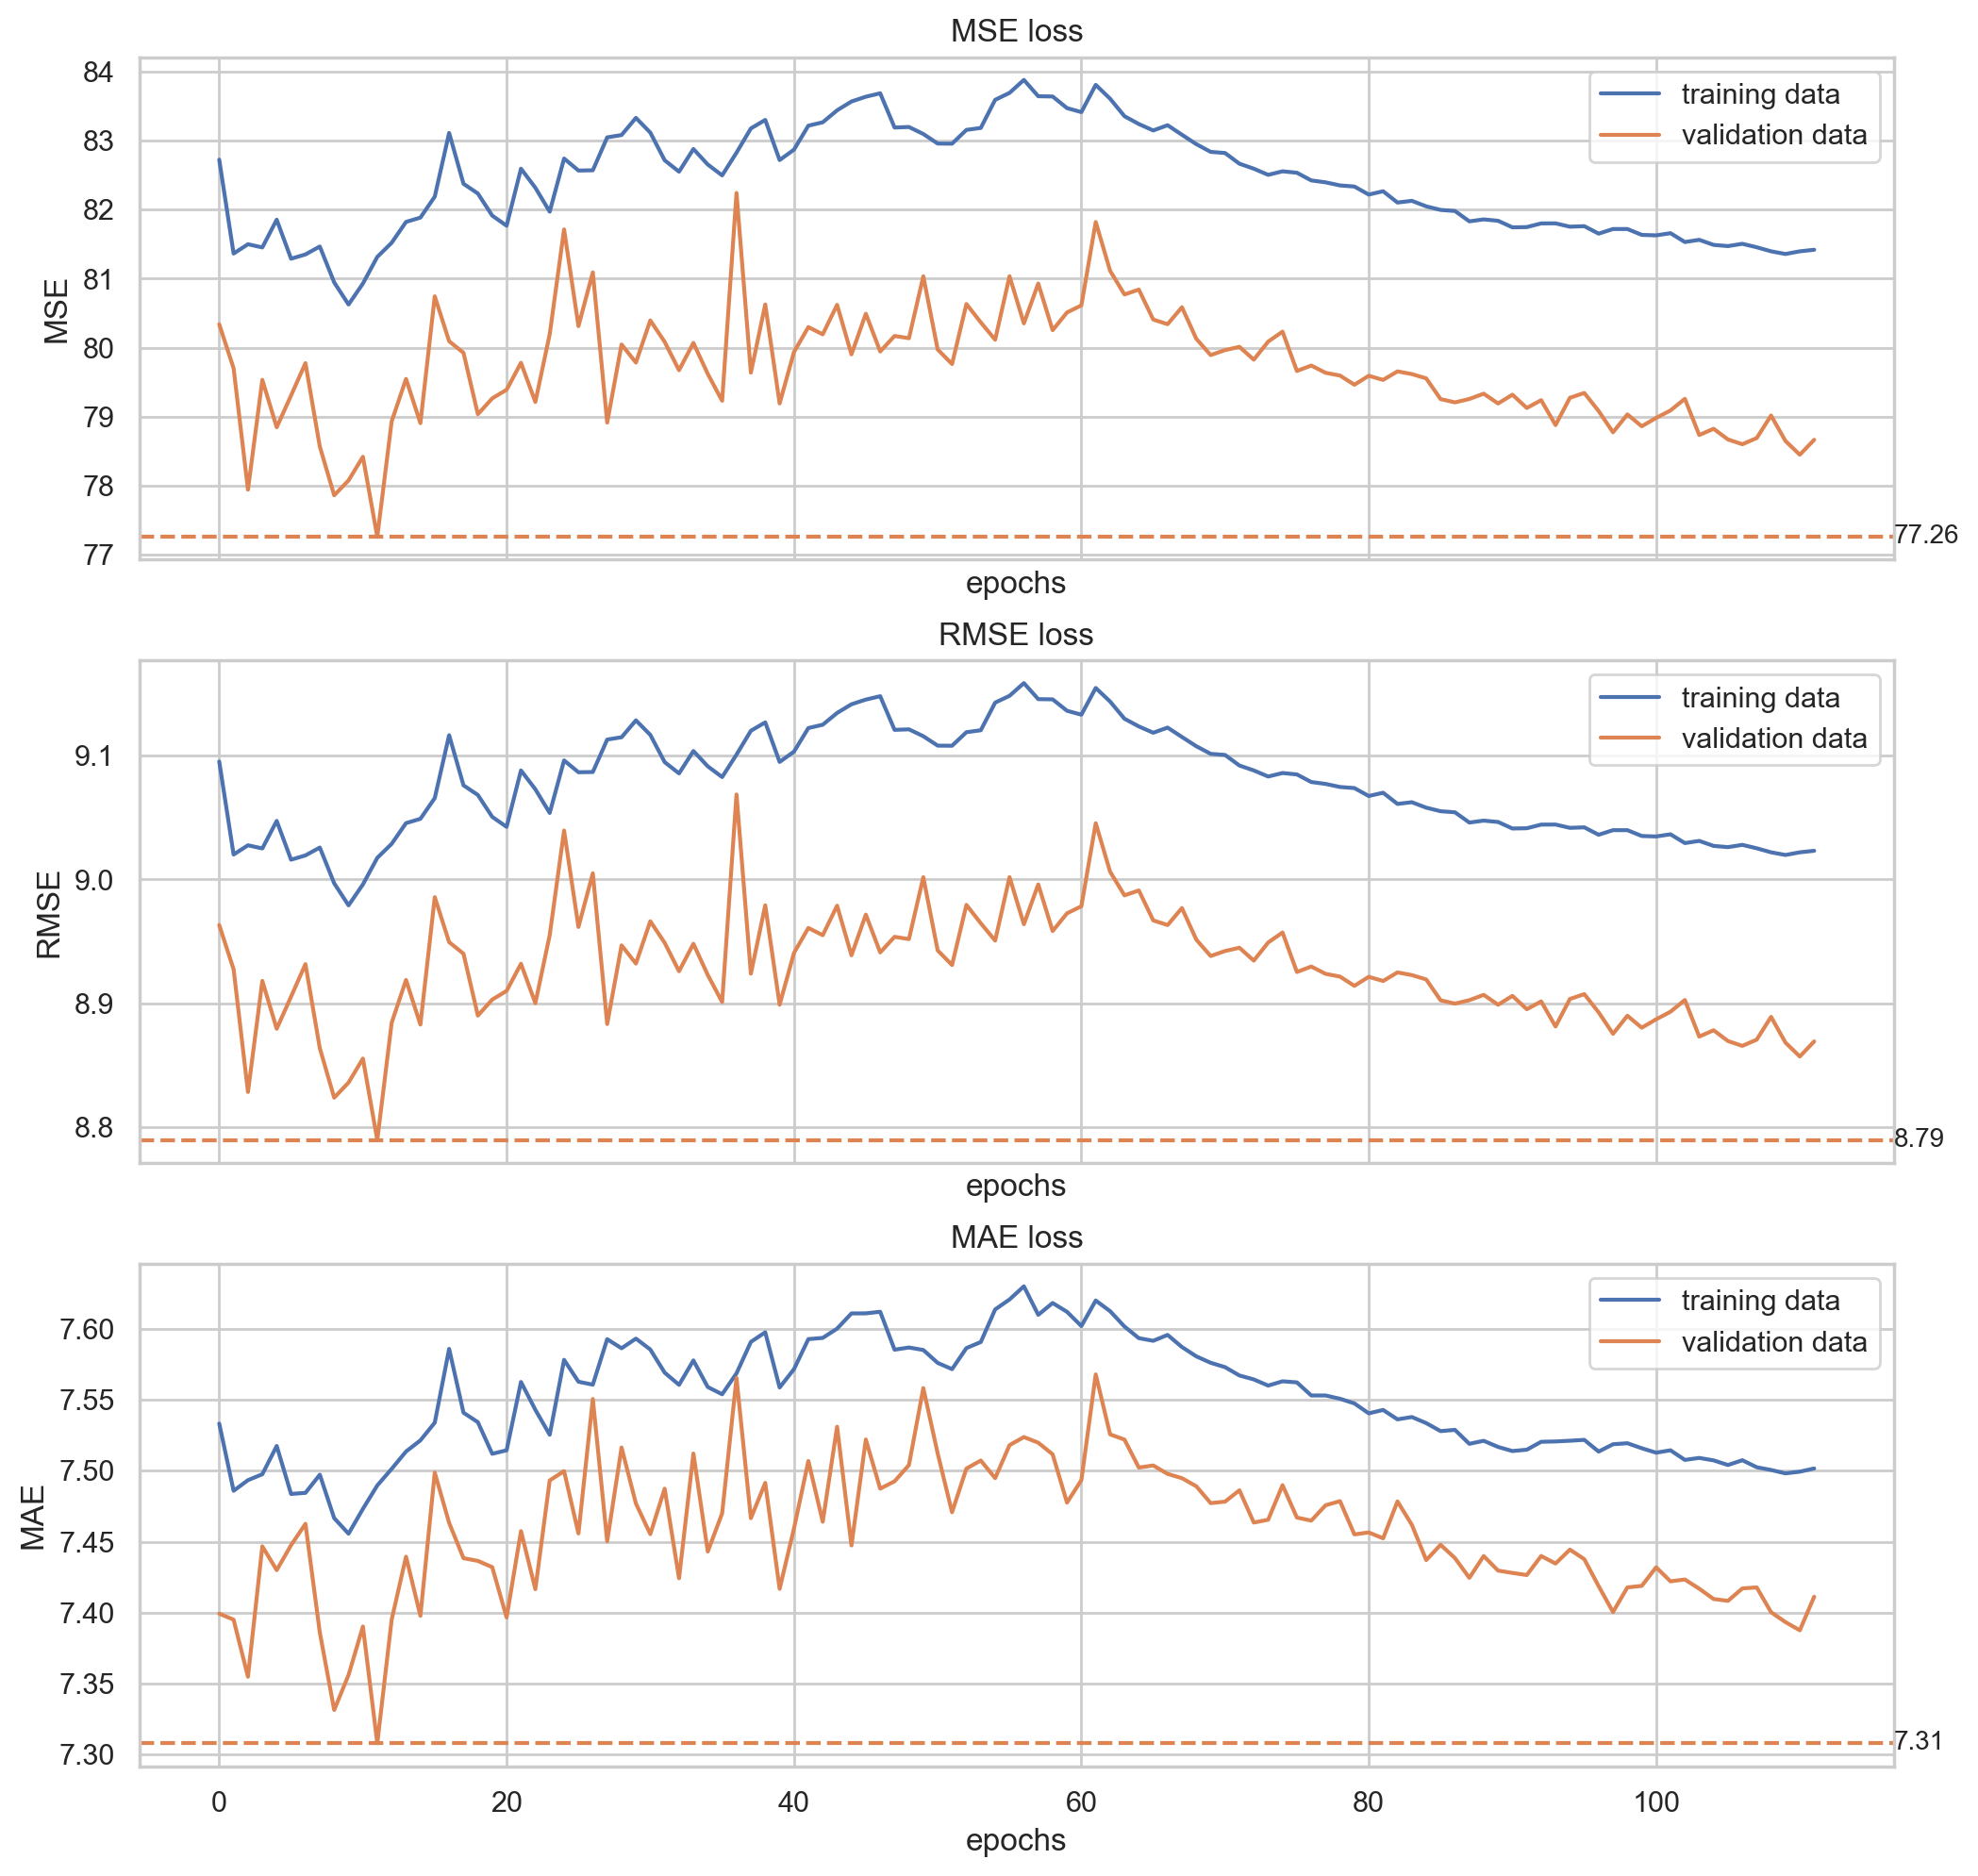

In [56]:
plot_loss(history)

In [57]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

filename = os.path.join(PATH_MODELS, 'FC_regressor_01')
model = tf.keras.models.load_model(filename + ".hdf5")

# MSE
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of simple FC neural network regressor: RMSE = {rmse} and MAE = {mae}.")

Performance of simple FC neural network regressor: RMSE = 8.962693403865986 and MAE = 7.322791660524111.


- Performance of 'FC_regressor_01': RMSE = 8.962693403865986 and MAE = 7.322791660524111. (Correct split)
- Performance of 'FC_regressor_02': RMSE = 8.89461832846391 and MAE = 7.288057913338504.
- Performance of 'FC_regressor_03': RMSE = 8.797764719465878 and MAE = 7.173652581160049.
- Performance of 'FC_regressor_04': RMSE = 8.918336755212458 and MAE = 7.307624677486689.
- Performance of 'FC_regressor_05': RMSE = 9.311148584537879 and MAE = 7.681811556401662.